<a href="https://colab.research.google.com/github/katarinagresova/DSIB01_2020/blob/main/Predictive_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrics

This part contains function for evaluating results of some predictive method. Function `print_metrics()` calculate metrics as sensitivity, specificity, precision, f1 score and accuracy. Then there are functions for plotting ROC, precision-recall and F!-threshold curves. All this can be run at once by using `evaluate_predictions()` function.

Input for evalution must be comma delimited file (for example csv) with rows with following structure `[samplename, realcateg, predictionscore]` where:

*   `samplename` = the name of this row
*   `realcateg` = 0 or 1
*   `predictionscore` = a value between 0 and 1




In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
from numpy import genfromtxt

In [ ]:
def generate_random_results(size, output_path):
  random_results = [
      [i for i in range(size)],
      [random.randint(0, 1) for _ in range(size)],
      [random.uniform(0, 1) for _ in range(size)]
  ]
  # transpose
  random_results = np.array(random_results).T.tolist()

  with open(output_path, 'w', newline='') as f:
      writer = csv.writer(f)
      writer.writerows(random_results)

In [ ]:
def read_csv_with_results(path_to_csv):
  # read file to np.array
  results = genfromtxt(path_to_csv, delimiter=',', skip_header=1)
  # get second column where true labels are
  y_true = results[:, 1]
  # get third column with prediction score
  y_pred = results[:, 2]

  return (y_true, y_pred)

In [ ]:
def print_metrics(y_true, y_probs, threshold):

  y_pred = np.where(y_probs > threshold, 1, 0)
  tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

  fpr = fp / (fp + tn)
  fnr = fn / (tp + fn)
  sensitivity = 1 - fnr
  specificity = 1 - fpr
  precision = tp / (tp + fp)
  f1 = tp / (tp + 0.5 * (fp + fn))
  accuracy = (tp + tn) / (tp + tn + fp + fn)

  print('Sensitivity:', sensitivity)
  print('Specificity:', specificity)
  print('Precision:', precision)
  print('F1:', f1)
  print('Accuracy', accuracy)

In [ ]:
def plot_roc(y_true, y_probs):

  fpr, tpr, _ = metrics.roc_curve(y_true,  y_probs)
  auc = metrics.roc_auc_score(y_true, y_probs)
  plt.plot(fpr, tpr, label="AUC=" + str(auc))
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.legend(loc=4)
  plt.show()

In [ ]:
def plot_precision_recall(y_true, y_probs):
  precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_probs)
  auc = metrics.auc(recall, precision)

  plt.plot(recall, precision,label="AUC=" + str(auc))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc=4)
  plt.show()

In [ ]:
def plot_threshold_f1(y_true, y_probs):
  steps = 1000
  thresholds = np.arange(0, 1, 1/steps)
  f1s = np.zeros(steps)
  for index, threshold in enumerate(thresholds):

    y_pred = np.where(y_probs > threshold, 1, 0)
    f1s[index] = metrics.f1_score(y_true, y_pred)

  plt.plot(thresholds, f1s)
  plt.xlabel("Threshold")
  plt.ylabel("F1")
  plt.show()

In [ ]:
def evaluate_predictions(results_file, threshold):
  y_true, y_probs = read_csv_with_results(results_file)
  print_metrics(y_true, y_probs, threshold)
  plot_roc(y_true, y_probs)
  plot_precision_recall(y_true, y_probs)
  plot_threshold_f1(y_true, y_probs)

Sensitivity: 0.5435684647302905
Specificity: 0.5241779497098646
Precision: 0.515748031496063
F1: 0.5292929292929293
Accuracy 0.5335335335335335


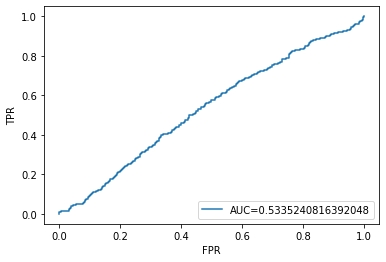

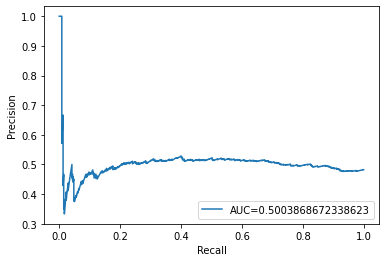

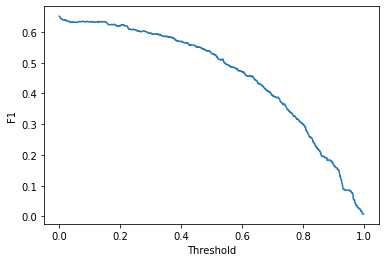

In [ ]:
# try evaluating with random results
generate_random_results(1000, 'results.csv')
evaluate_predictions('results.csv', 0.5)

# Predictor

This part contains simple classification model to generate some results that can be evaluated by functions from previous part.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip3 install biopython

     |████████████████████████████████| 2.3MB 3.2MB/s 


In [ ]:
from Bio import SeqIO
import re
import csv

In [ ]:
def score_sequence(seq, regex):
  return len(re.findall(regex, str(seq))) / len(seq)

In [ ]:
def make_result_row(record, regex, positive):
  # each row of results has this structure [samplename, realcateg, predictionscore] where:
  #   samplename = the name of this row
  #   realcateg = 0 or 1
  #   predictionscore = a value between 0 and 1
  current_result = []
  current_result.append(record.id)
  current_result.append(1) if positive else current_result.append(0)
  current_result.append(score_sequence(record.seq, regex))

  return current_result

In [ ]:
def predict_sequences(pos_path, neg_path, regex, results_file):
  results = []
  for record in SeqIO.parse(pos_path, "fasta"):  
    results.append(make_result_row(record, regex, True))

  for record in SeqIO.parse(neg_path, "fasta"):  
    results.append(make_result_row(record, regex, False))

  with open(results_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(results)

In [ ]:
pos_path = '/content/drive/My Drive/DSIB01/hw3/PUM2_10K_window-50_with_sequences.fa'
neg_path = '/content/drive/My Drive/DSIB01/hw3/neg_11_5K_window-50_with_sequences.fa'
regexes = ['TGTA', '[TA]GT[TA]']

for regex in regexes:
  predict_sequences(pos_path, neg_path, regex, 'results_' + regex + '.csv')

Sensitivity: 0.0005082850462538868
Specificity: 1.0
Precision: 1.0
F1: 0.001016053647632595
Accuracy 0.5412467338559164


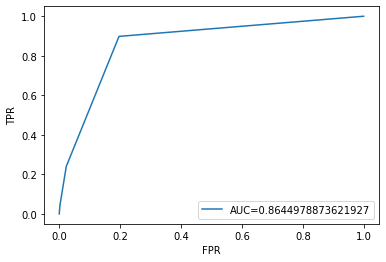

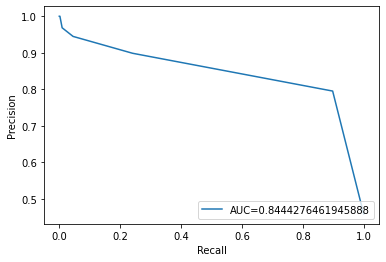

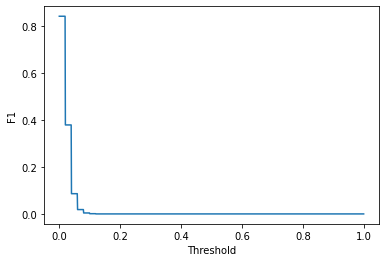

In [ ]:
evaluate_predictions('results_TGTA.csv', 0.1)

Sensitivity: 0.002134797194266569
Specificity: 0.999396291504959
Precision: 0.75
F1: 0.004257475924987329
Accuracy 0.5416666666666666


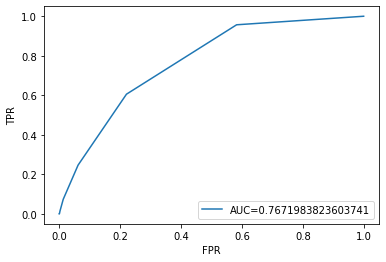

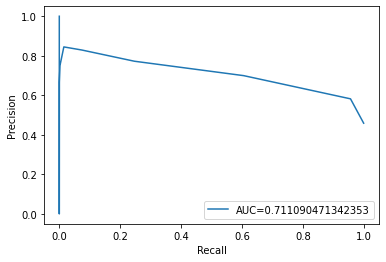

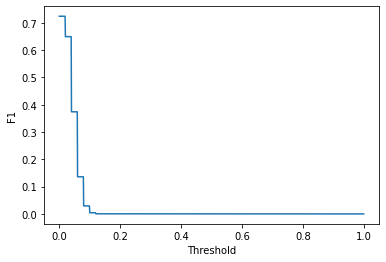

In [ ]:
evaluate_predictions('results_[TA]GT[TA].csv', 0.1)